In [1]:
import pandas as pd
from os.path import join

from sklearn import svm
from pandas import DataFrame
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
import os
os.chdir('/home/tai/Projects/kickstarter_prediction')

## Check the with SVM Quantile

In [3]:
train_quantile = pd.read_csv('data/data_quantile_transform/train_quantile_transform.csv', encoding='latin1', low_memory=True)
test_quantile = pd.read_csv('data/data_quantile_transform/test_quantile_transform.csv', encoding='latin1', low_memory=True)
val_quantile = pd.read_csv('data/data_quantile_transform/val_quantile_transform.csv', encoding='latin1', low_memory=True)

In [4]:
train_quantile_large = pd.concat([train_quantile,val_quantile], axis=0)

In [5]:
train_x = train_quantile_large.drop(['success'], axis=1)
train_y = train_quantile_large.success
test_x = test_quantile.drop(['success'], axis=1)
test_y = test_quantile.success

In [6]:
train_x.shape

(232170, 221)

In [19]:
pca=PCA() 
pca.fit(train_x) 
train_x_pca=pca.transform(train_x) 

In [10]:
ex_variance=np.var(train_x_pca,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)

In [11]:
ex_variance_ratio

array([0.84883124, 0.03410311, 0.02902846, 0.01857401, 0.01499329,
       0.01326282, 0.01126795, 0.01090785, 0.00960956, 0.00942171])

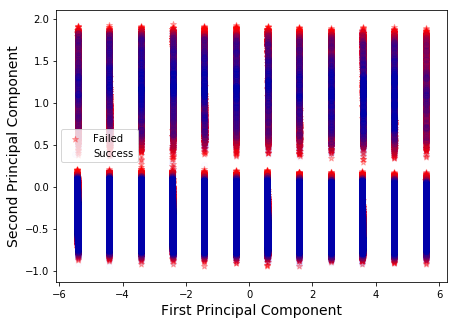

In [17]:
Xax=train_x_pca[:,0]
Yax=train_x_pca[:,1]
labels=train_y
cdict={0:'red',1:'blue'}
labl={0:'Failed',1:'Success'}
marker={0:'*',1:'o'}
alpha={0:.3, 1:.01}
fig,ax=plt.subplots(figsize=(7,5))
fig.patch.set_facecolor('white')
for l in np.unique(labels):
 ix=np.where(labels==l)
 ax.scatter(Xax[ix],Yax[ix],c=cdict[l],s=40,
           label=labl[l],marker=marker[l],alpha=alpha[l])
# for loop ends
plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)
plt.legend()
plt.show()

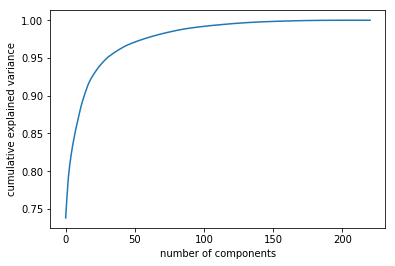

In [20]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [19]:
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
supp_vec_machine = svm.SVC()
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('svm', supp_vec_machine)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [int(i*221/100) for i in range(20, 101, 20)],
    'svm__kernel' : ['linear'],
    'svm__C' : [0.001, 0.01, 1],
    'svm__gamma': [0.001, 0.01, 1]
    
}
search = GridSearchCV(pipe, param_grid, iid=False, cv=5,
                      return_train_score=False, verbose=50, n_jobs=64)
search.fit(train_x, train_y)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed: 66.1min
[Parallel(n_jobs=64)]: Done   2 tasks      | elapsed: 71.9min
[Parallel(n_jobs=64)]: Done   3 tasks      | elapsed: 72.1min
[Parallel(n_jobs=64)]: Done   4 tasks      | elapsed: 72.4min
[Parallel(n_jobs=64)]: Done   5 tasks      | elapsed: 72.5min
[Parallel(n_jobs=64)]: Done   6 tasks      | elapsed: 72.5min
[Parallel(n_jobs=64)]: Done   7 tasks      | elapsed: 72.6min
[Parallel(n_jobs=64)]: Done   8 tasks      | elapsed: 72.7min
[Parallel(n_jobs=64)]: Done   9 tasks      | elapsed: 72.7min
[Parallel(n_jobs=64)]: Done  10 tasks      | elapsed: 72.8min
[Parallel(n_jobs=64)]: Done  11 tasks      | elapsed: 73.0min
[Parallel(n_jobs=64)]: Done  12 tasks      | elapsed: 73.0min
[Parallel(n_jobs=64)]: Done  13 tasks      | elapsed: 73.0min
[Parallel(n_jobs=64)]: Done  14 tasks      | elapsed: 7

[Parallel(n_jobs=64)]: Done 223 out of 225 | elapsed: 779.9min remaining:  7.0min
[Parallel(n_jobs=64)]: Done 225 out of 225 | elapsed: 787.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid=False, n_jobs=64,
       param_grid={'pca__n_components': [44, 88, 132, 176, 221], 'svm__kernel': ['linear'], 'svm__C': [0.001, 0.01, 1], 'svm__gamma': [0.001, 0.01, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=None, verbose=50)

In [20]:
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.783):
{'pca__n_components': 221, 'svm__C': 1, 'svm__gamma': 0.001, 'svm__kernel': 'linear'}


### Test on test set

In [23]:
model = svm.SVC(C=1, gamma=0.001, kernel='linear')
model.fit(train_x, train_y)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [26]:
y_pred = model.predict(test_x)

In [28]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_y, y_pred)

In [29]:
accuracy

0.7832706880263713

## Train with the post feature remove

In [9]:
train_quantile.columns

Index(['usd_goal_real', 'success', 'contain_special_symbols', 'name_length',
       'num_vowels', 'num_cap', 'num_whitespace', 'contain_bad_word',
       'subjectivity', 'polarity',
       ...
       'country_JP', 'country_LU', 'country_MX', 'country_N,0"', 'country_NL',
       'country_NO', 'country_NZ', 'country_SE', 'country_SG', 'country_US'],
      dtype='object', length=222)

In [10]:
train_x_no_post = train_quantile_large.drop(['success', 'pledged_per_backer', 'required_backers','required_backers_per_day'], axis=1)
train_y = train_quantile_large.success
test_x_no_post = test_quantile.drop(['success', 'pledged_per_backer', 'required_backers','required_backers_per_day'], axis=1)
test_y = test_quantile.success

In [ ]:
model2 = svm.SVC(C=1, gamma=0.001, kernel='linear')
model2.fit(train_x_no_post, train_y)